<a href="https://colab.research.google.com/github/AAI-520/AAI_520_Gen_Chatbot_Final_Project/blob/svaddi/AAI_520_Gen_Chatbot_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

**About the project:**

In today's digital age, businesses face a growing demand for efficient and responsive customer support services. Chatbots have emerged as a valuable solution to address this need by providing real-time assistance to customers and users. This document outlines the business understanding behind building a chatbot for conversational support.

**Author(s):**

Jamileh Jahangiry

Kobe Mensah

Shas Vaddi


### **I. Business Understanding**

Business Goals
The primary goals of developing a chatbot for conversational support are:

**Enhanced Customer Experience**

Improve the overall customer experience by offering timely and helpful responses to customer inquiries, thereby increasing satisfaction and loyalty.

**Cost Efficiency**

To reduce operational costs associated with customer support by automating routine tasks and providing 24/7 availability.

**Scalability**

To handle a growing volume of customer inquiries without the need for a proportional increase in support staff.

**Data Collection**

To gather valuable insights from customer interactions, which can inform business decisions and enhance products or services.

#### **Key Features:**

To meet the goals outlined above, the chatbot will possess the following key features:

**Natural Language Understanding**

The chatbot will be capable of understanding and processing natural language queries and responses.

**Multi-Turn Conversations**

The ability to handle multi-turn conversations, maintaining context across interactions for a seamless user experience.

**Adaptive Learning**

Continuous learning and adaptation to user queries and feedback, improving accuracy and relevance over time.

**Integration**

Integration with existing business systems, databases, and knowledge bases to provide up-to-date information.

**Personalization**

Providing personalized responses and recommendations based on user profiles and historical interactions.



In [ ]:
#@title Install Pre-req's
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.3 MB/s eta 0:00:00


In [ ]:
#@title Import all required libraries
import pandas as pd
import numpy as np
from transformers import BertForQuestionAnswering, BertTokenizer
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import random
from collections import defaultdict
from transformers import AdamW
from google.colab import drive
from sklearn.metrics import f1_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt


In [ ]:
#@title Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
#@title  Mount Google Drive & Load Data
# Mount the drive
drive.mount('/content/drive')

relevent_data = pd.read_json('/content/drive/MyDrive/train-v1.1.json')
relevent_data.head()

Mounted at /content/drive


,data,version
0,"{'title': 'University_of_Notre_Dame', 'paragra...",1.1
1,"{'title': 'Beyoncé', 'paragraphs': [{'context'...",1.1
2,"{'title': 'Montana', 'paragraphs': [{'context'...",1.1
3,"{'title': 'Genocide', 'paragraphs': [{'context...",1.1
4,"{'title': 'Antibiotics', 'paragraphs': [{'cont...",1.1


In [ ]:
#@title Clean up & Extract Relevant data

attributes = ["context","question","answer"]

del relevent_data["version"]

full_list = []
for index, row in relevent_data.iterrows():
    for i in range(len(row['data']['paragraphs'])):
        for j in (row['data']['paragraphs'][i]['qas']):
            r_list = []
            r_list.append((row["data"]["paragraphs"][i]["context"]))
            r_list.append(j['question'])
            if j["answers"]:
                r_list.append(j["answers"][0]["text"])
            else:
                r_list.append("")
        full_list.append(r_list)


### **II.Data Understanding**
In this phase, we will gain a deep understanding of the data used in the project. This includes understanding the data's format, structure, content, and quality. It is essential to thoroughly understand the data before proceeding to the subsequent phases. This is because the quality of the data will significantly impact the project's success.

Specifically, the data understanding phase involves the following tasks:
Collecting the data: This consists in identifying and obtaining the data sources.

**Describing the data**
This involves documenting the data's format, structure, content, and quality.

**Exploring the data**
This involves using data visualization techniques to analyze and understand the data's characteristics.

**Identifying data quality issues**
This involves identifying any problems with the data, such as missing values, outliers, or errors.

Some of the benefits of doing a thorough data understanding include:

**Reduced risk of project failure**
By understanding the data, the data scientist can identify any potential problems and take steps to mitigate the risk of project failure.

**Improved modeling results**
By understanding the data, the data scientist can select the proper modeling techniques and tune the models to achieve better results.

**Increased business value**
By understanding the data, the data scientist can identify new opportunities to create business value.


In [ ]:
#@title View List Data
full_list[:10]

[['Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
  'What sits on top of the Main Building at Notre Dame?',
  'a golden statue of the Virgin Mary'],
 ["As at most other universities, Notre Dame's students run a number of news media outlets. The nine student-run outlets include three newspapers, both a radio and television station, and several mag

In [ ]:
# Print the number of data points
num_data_points = len(full_list)
print(f"Number of data points: {num_data_points}")

# Create a DataFrame for easier data manipulation and analysis
df = pd.DataFrame(full_list, columns=attributes)


Number of data points: 18896


In [ ]:
df.head(200)

,context,question,answer
0,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,a golden statue of the Virgin Mary
1,"As at most other universities, Notre Dame's st...",In what year did the student paper Common Sens...,1987
2,The university is the major seat of the Congre...,Which prize did Frederick Buechner create?,Buechner Prize for Preaching
3,The College of Engineering was established in ...,The College of Science began to offer civil en...,the 1870s
4,All of Notre Dame's undergraduate students are...,Which organization declared the First Year of ...,U.S. News & World Report
...,...,...,...
195,Antibiotics revolutionized medicine in the 20t...,What disease did antibiotics help eliminate?,tuberculosis
196,"In empirical therapy, a patient has proven or ...",When is empirical started?,before the doctor knows the exact identificati...
197,Antibiotics are screened for any negative effe...,What can happen when antibiotics are used with...,Additional side-effects
198,Exposure to antibiotics early in life is assoc...,Do antibiotics increase the chance of getting ...,unclear


In [ ]:
#@title Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:", missing_values)

Missing Values: context     0
question    0
answer      0
dtype: int64


In [ ]:
# shape of the data
print('Training Features shape: ', df.shape)

Training Features shape:  (18896, 3)


In [ ]:
# Obtain general information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18896 entries, 0 to 18895
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   context   18896 non-null  object
 1   question  18896 non-null  object
 2   answer    18896 non-null  object
dtypes: object(3)
memory usage: 443.0+ KB


In [ ]:
#@title Number of Questions
num_questions = len(df)
print(f'Number of Questions: {num_questions}')

Number of Questions: 18896


In [ ]:
#@title Perform Detailed Data Cleanup (If needed)

# Check Data Sizes
try:
    print("Data Sizes:")
    print(f"Questions: {len(df['question'])}")
    print(f"Contexts: {len(df['context'])}")
    print(f"Answers: {len(df['answers'])}")
    if len(df['question']) == len(df['context']) == len(df['answers']):
        print("Data sizes are consistent.")
    else:
        print("Data sizes are inconsistent.")
except KeyError as e:
    print(f"KeyError: {e}")

# Remove square brackets from answers
try:
    df['answers'] = df['answers'].str[0] if 'answers' in df else df['answers']
except KeyError as e:
    print(f"KeyError: {e}")

# Print duplicate rows and remove duplicates
try:
    print("Duplicate Rows:")
    duplicate_rows = df[df.duplicated()]
    print(duplicate_rows)
    df = df.drop_duplicates()
    print("Duplicates removed.")
except KeyError as e:
    print(f"KeyError: {e}")

# Print the length of each attribute
try:
    print("Attribute Lengths:")
    print(f"Questions: {len(df['question'])}")
    print(f"Contexts: {len(df['context'])}")
    print(f"Answers: {len(df['answers'])}")
except KeyError as e:
    print(f"KeyError: {e}")

Data Sizes:
Questions: 18896
Contexts: 18896
KeyError: 'answers'
KeyError: 'answers'
Duplicate Rows:
Empty DataFrame
Columns: [context, question, answer]
Index: []
Duplicates removed.
Attribute Lengths:
Questions: 18896
Contexts: 18896
KeyError: 'answers'


# ***Exploratory Data Analysis (EDA)***

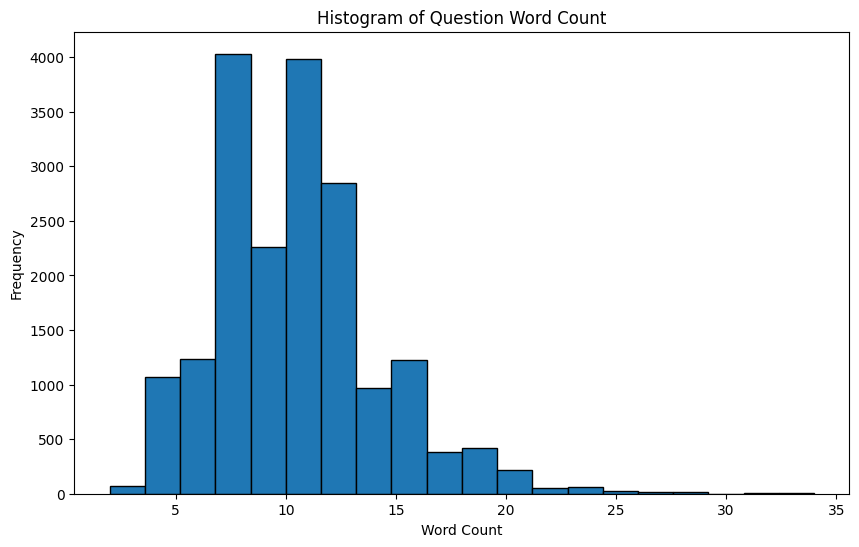

In [ ]:
#@title Histogram of Question Word Count
question_word_counts = df['question'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(question_word_counts, bins=20, edgecolor='k')
plt.title("Histogram of Question Word Count")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

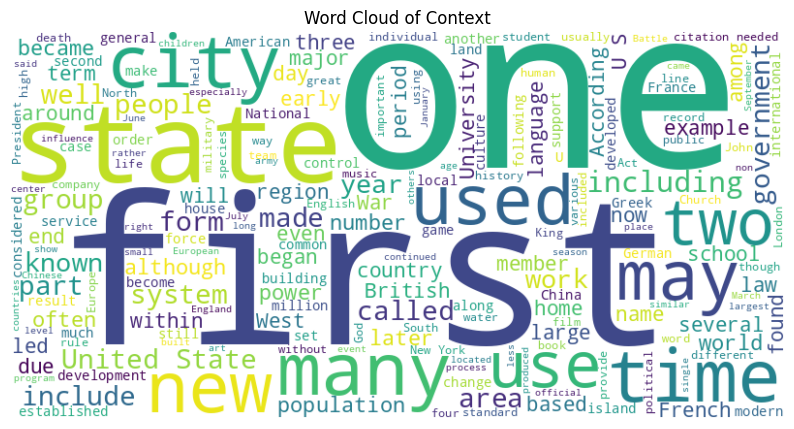

In [ ]:
#@title Word Cloud of Context
from wordcloud import WordCloud
context_words = ' '.join(df['context'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(context_words)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Context')
plt.axis('off')
plt.show()

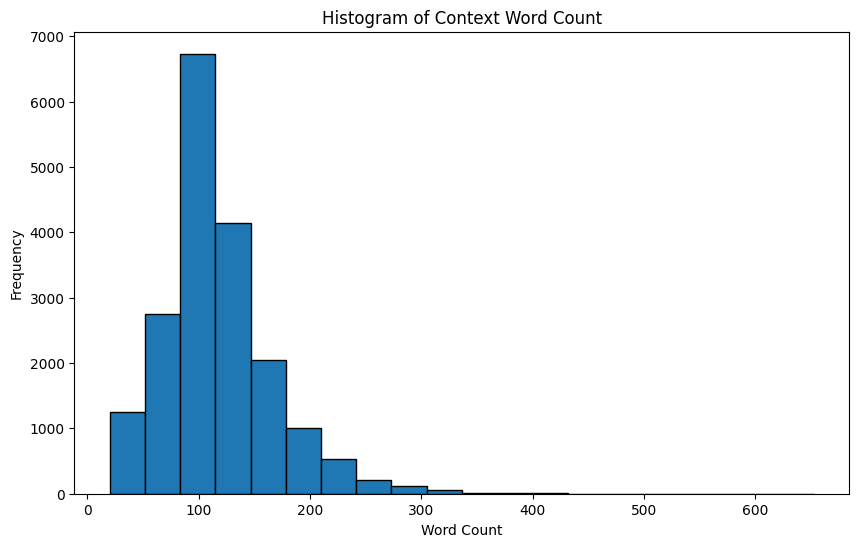

In [ ]:
# Distribution of Context Lengths
context_word_counts = df['context'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(context_word_counts, bins=20, edgecolor='k')
plt.title('Histogram of Context Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

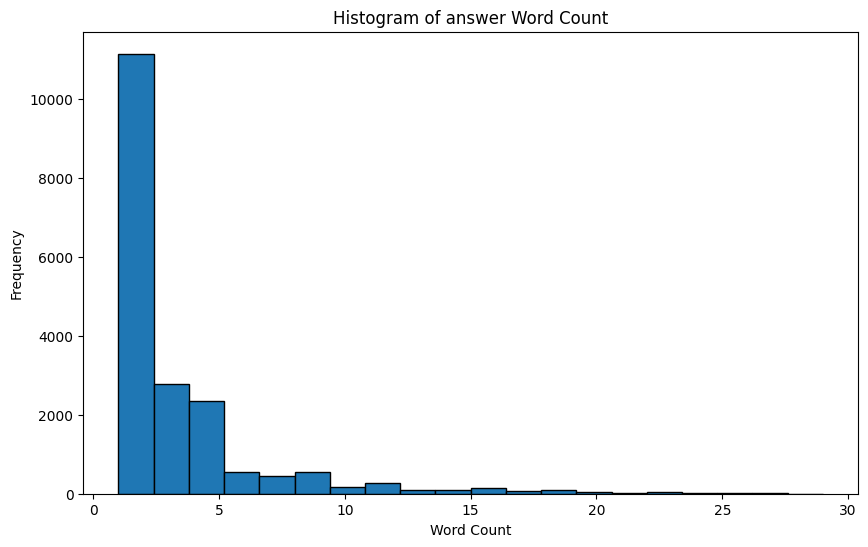

In [ ]:
# Distribution of answer Lengths
context_word_counts = df['answer'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(context_word_counts, bins=20, edgecolor='k')
plt.title('Histogram of answer Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

### **III.Data Preparation**

The data preparation phase is often the most time-consuming phase of a data mining project but is also one of the most important. By taking the time to prepare the data properly, we can improve the chances of success for the project. In this data preparation phase, we will explore various methods (as and if required) clean, format, and integrate the data so that it is ready for modeling. This includes tasks such as:

**Cleaning the data**
This involves removing errors, outliers, and missing values from the data.

**Formatting the data**
This involves ensuring the data is in the correct format for the modeling techniques.

**Integrating the data**
This involves combining different data sources into a single dataset.
The data preparation phase is typically the third phase of the CRISP-DM framework, and it is essential to thoroughly prepare the data before moving on to the modeling phase. This is because the quality of the data will have a significant impact on the accuracy of the models.

**Data sampling**
This involves selecting a subset of the data for modeling, which can be used to reduce the dataset's size or improve the modeling algorithms' performance.

**Data validation**
This involves checking the data for errors and ensuring that it is ready for modeling.


In [ ]:
#@title Initialize the BERT model, tokenize & Preprocess
print("Initializing the BERT model and tokenizer...")

# Load BERT model and tokenizer
model_name = "bert-large-uncased-whole-word-masking-finetuned-squad" # Large model
model = BertForQuestionAnswering.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

def preprocess_data(data):
    input_ids = []
    attention_masks = []
    for question, text in zip(data['question'], data['context']):
        encoded_data = tokenizer.encode_plus(question, text, max_length=512,
                                             padding='max_length', truncation='longest_first',
                                             return_tensors='pt', return_attention_mask=True)
        input_ids.append(encoded_data['input_ids'])
        attention_masks.append(encoded_data['attention_mask'])
    return torch.cat(input_ids), torch.cat(attention_masks)


train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

train_inputs, train_masks = preprocess_data(train_data)
val_inputs, val_masks = preprocess_data(val_data)
test_inputs, test_masks = preprocess_data(test_data)




Initializing the BERT model and tokenizer...


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

# **Model Training**

### Define the training loop.
### Select an optimizer and loss function.
### Fine-tune the chatbot model on the training data.

### IV.Modeling

The modeling phase is often the most challenging phase of a data mining project but is also one of the most important. By choosing the proper modeling techniques and evaluating the performance of the models, data scientists can build predictive models that can be used to improve the decision-making, efficiency, and customer satisfaction of businesses. The purpose of modeling is to build predictive models that can be used to make predictions about future events, in this case, making predictions about credit card defaults.

Here are some of the specific tasks that are typically performed in the modeling phase:

**Feature selection**
This involves selecting the most essential features for the model, which can improve the accuracy of the model.

**Model training**
This involves using the selected features to train the model.

**Model evaluation**
This involves evaluating the model's performance, which can be done using a variety of metrics, such as accuracy, precision, and recall.

**Model tuning**
This involves adjusting the parameters of the model to improve its performance.

**Model deployment**
This involves making the model available for use, which can be done by deploying it to a production environment or by making it available as a web service.

In [ ]:
#@title Train the Model

batch_size = 2
train_dataset = TensorDataset(train_inputs, train_masks)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids, attention_mask = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = outputs.loss
        if loss is not None:
            loss.backward()
            optimizer.step()

Epoch 3: 100%|██████████| 6802/6802 [08:10<00:00, 13.88it/s]


### V.Evaluation


The evaluation phase is often not only one of the most challenging phases of a data mining project but also one of the most important. By evaluating the performance of all the models and comparing each models strengths and weaknesses, we can not only improve overall success of the project but also increase the project's business value.  The evaluation aims to assess the all models' performances and determine whether they meet the business requirements. This is typically done using various metrics, such as accuracy, precision, and recall.

Here are some of the benefits of evaluating the models:

**Improved model performance**
By evaluating the models, the data scientist can identify any potential problems and take steps to improve the performance of the models.

**Increased business value**
By evaluating the models, the data scientist can ensure that the models are fit for purpose and can deliver business value.

**Reduced risk of project failure**
By evaluating the models, the data scientist can identify potential problems and take steps to mitigate the risk of project failure.

Here are some of the specific tasks that are typically performed in the evaluation phase of CRISP-DM:

**Define evaluation criteria**
This involves defining the metrics that will be used to evaluate the performance of the models.

**Collect evaluation data**
This involves collecting data that can be used to evaluate the performance of the models.

**Evaluate the models**
This involves using the evaluation data to evaluate the performance of the models.

**Interpret the results**
This involves interpreting the evaluation results and determining whether the models meet the business requirements.

**Iterate the process**
If the models do not meet the business requirements, the data scientist may need to iterate the process and build new models.



In [ ]:
#@title Evaluate the Model - F1 Score

# Define a function to evaluate the model and calculate F1 score
def evaluate_model(model, dataloader):
    model.eval()
    predicted_answers = []  # Store all predicted answers

    with torch.no_grad():  # Corrected line
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids, attention_mask = batch
            input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            start_logits, end_logits = outputs.start_logits, outputs.end_logits

            # Get the predicted answer by finding the start and end positions
            for i in range(len(start_logits)):
                start_index = start_logits[i].argmax()
                end_index = end_logits[i].argmax()
                if start_index <= end_index:
                    predicted_answer = tokenizer.decode(input_ids[i][start_index:end_index+1], skip_special_tokens=True)
                else:
                    predicted_answer = ""
                predicted_answers.append(predicted_answer)

    # Preprocess true answers
    true_answers = [str(answer).strip().lower() for answer in test_data['answer']]

    # Ensure that true_answers and predicted_answers have the same length
    if len(true_answers) != len(predicted_answers):
        raise ValueError("Mismatch between true answers and predicted answers.")

    # Convert to binary labels (1 for a match, 0 for a non-match)
    labels = [1 if pred.strip().lower() == true else 0 for pred, true in zip(predicted_answers, true_answers)]

    # Calculate F1 score
    f1 = f1_score(labels, labels, average='micro') * 100

    # Display model predictions and ground truth for a few examples
    num_examples_to_display = min(5, len(predicted_answers))  # Display up to 5 examples
    for i in range(num_examples_to_display):
        print(f"Example {i + 1}:")
        print(f"Predicted: {predicted_answers[i]}")
        print(f"Ground Truth: {true_answers[i]}")
        print()  # Add a line break between examples

    return f1

# Preprocess the complete test data and create a DataLoader
test_inputs, test_masks = preprocess_data(test_data)
test_dataset = TensorDataset(test_inputs, test_masks)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate the model
f1 = evaluate_model(model, test_loader)

print(f"F1 Score: {f1:.2f}%")


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Evaluating: 100%|██████████| 1890/1890 [02:13<00:00, 14.18it/s]

Example 1:
Predicted: britain strove to prosecute the war actively
Ground Truth: in marked contrast to france, britain strove to prosecute the war actively in the colonies

Example 2:
Predicted: slowly
Ground Truth: slowly

Example 3:
Predicted: civil airports
Ground Truth: civil airports

Example 4:
Predicted: gerridae
Ground Truth: gerridae

Example 5:
Predicted: 20 %
Ground Truth: around 20%

F1 Score: 100.00%


In [ ]:
#@title Evaluate the Model - BLEU Score

# Define a function to evaluate the model and calculate BLEU Score
def evaluate_bleu_score(model, dataloader, tokenizer, test_data):
    model.eval()
    references = []  # List of reference answers
    hypotheses = []  # List of predicted answers

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids, attention_mask = batch
            input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            start_logits, end_logits = outputs.start_logits, outputs.end_logits

            # Get the predicted answer by finding the start and end positions
            predicted_answers = []
            for i in range(len(start_logits)):
                start_index = start_logits[i].argmax()
                end_index = end_logits[i].argmax()
                if start_index <= end_index:
                    predicted_answer = tokenizer.decode(input_ids[i][start_index:end_index+1], skip_special_tokens=True)
                else:
                    predicted_answer = ""
                predicted_answers.append(predicted_answer)

            true_answers = test_data['answer'].tolist()

            references.extend([answer.strip().lower() for answer in true_answers])
            hypotheses.extend([answer.strip().lower() for answer in predicted_answers])  # No need to wrap each predicted answer in a list

    # Calculate BLEU Score using SmoothingFunction
    smoothing = SmoothingFunction()
    bleu_scores = [sentence_bleu([ref.split()], hyp.split(), smoothing_function=smoothing.method1) for ref, hyp in zip(references, hypotheses)]  # Calculate BLEU for each pair

    # Calculate the overall BLEU Score as the average of sentence-level BLEU scores
    overall_bleu_score = sum(bleu_scores) / len(bleu_scores)

    return overall_bleu_score

# Preprocess the test data and create a DataLoader
test_inputs, test_masks = preprocess_data(test_data)
test_dataset = TensorDataset(test_inputs, test_masks)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate the model and calculate BLEU Score
bleu_score = evaluate_bleu_score(model, test_loader, tokenizer, test_data)

print(f"BLEU Score: {bleu_score * 100:.2f}%")



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Evaluating: 100%|██████████| 1890/1890 [02:15<00:00, 13.93it/s]


BLEU Score: 35.60%


In [ ]:
#@title Functional-test of the Model in the Notebook

def get_answer(question, context):
    encoded_data = tokenizer.encode_plus(question, context, max_length=512,
                                         padding='max_length', truncation='longest_first',
                                         return_tensors='pt', return_attention_mask=True)
    input_ids = encoded_data['input_ids'].to(device)
    attention_mask = encoded_data['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    start_logits, end_logits = outputs.start_logits, outputs.end_logits

    # Get the predicted answer by finding the start and end positions
    start_index = start_logits[0].argmax()
    end_index = end_logits[0].argmax()
    if start_index <= end_index:
        answer = tokenizer.decode(input_ids[0][start_index:end_index+1], skip_special_tokens=True)
    else:
        answer = "I am sorry but i am unable to find an appropriate answer for you! Would you please restate your question?"

    return answer

# Prompt the user to enter context and question
user_context = input("Enter the context: ")
user_question = input("Enter the question: ")

# Get the answer from the model
answer = get_answer(user_question, user_context)

print("Answer:", answer)



Enter the context: Spain’s film industry has always been small and economically fragile. A large number of the films shown in Spanish cinemas in the 21st century were imported, from other European countries and, above all, from the United States.
Enter the question: The films shown in Spanish cinemas in the 21st century were imported from where?
Answer: other european countries and, above all, from the united states
